# 1. Introduction

The document will walk you through the codes to build the default prediction model using Python. All the process are highlighted using heading

# 2. Load Dataset

In [73]:
import pandas
import random
import pandas as pd
from datetime import datetime
import dateutil
from dateutil.parser import parse
import numpy as np
from sklearn import preprocessing
from collections import defaultdict

filename = "raw-data.csv"
n = sum(1 for line in open(filename)) - 1 #number of records in file (excludes header)
s = 100000 #desired sample size
skip = sorted(random.sample(range(1,n+1),n-s)) #the 0-indexed header will not be included in the skip list
df = pandas.read_csv(filename, skiprows=skip)

### 2.1 Simple examination of how the data looks like

In [74]:
df.head() #list the first 5 records

,member_id,int_rate,installment,sub_grade,emp_length,annual_inc,issue_d,dti,delinq_2yrs,inq_last_6mths,...,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,mo_sin_earliest_cr_line,label,percent_bc_sats,percent_bc_open_to_buy,percent_sats,percent_rev_tl_bal_gt_0,percent_tot_cur_bal_of_hi_cred_lim
0,40375473,17.14,319.08,180,10,125000.00,Dec 2014,8.31,1,0,...,18007,4400,18000,170.00,0,0.60,0.00,1.00,1.00,0.71
1,40385055,20.99,405.72,230,3,48000.00,Dec 2014,17.53,0,0,...,21212,10200,14857,109.00,0,0.50,0.75,1.00,1.00,0.82
2,39153308,12.39,240.49,100,5,84000.00,Dec 2014,18.79,0,1,...,64952,19800,67220,102.00,0,1.00,0.78,1.00,1.00,0.80
3,40545123,12.39,736.10,100,10,133995.00,Dec 2014,9.21,0,1,...,28439,30900,0,305.00,0,0.71,0.21,1.00,1.00,0.92
4,40375121,12.99,875.92,110,2,68000.00,2014-12,27.29,0,0,...,97659,22100,80275,156.00,0,0.83,0.16,1.00,1.00,0.91


In [75]:
df['issue_d']  = pd.to_datetime(df['issue_d']) 

In [76]:
df = df[df['issue_d'] < '2015-01-01']

In [77]:
df['label'].value_counts() #check target counts

0    23182
1     4785
Name: label, dtype: int64

In [69]:
from sklearn.cross_validation import train_test_split

train, test = train_test_split(df, test_size = 0.3)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

# 3. Data Cleaning and Transformation

## 3.1 Check Missing values and Cardinality 

In [26]:
df1 = df.copy()

In [27]:
miss_df = pd.DataFrame({'Miss_count':df.isnull().sum(),'Miss_per':df.isnull().mean()*100,'Cardinality':df.nunique()})

In [28]:
miss_df.sort_values('Miss_per',ascending=False)

,Cardinality,Miss_count,Miss_per
mths_since_recent_bc_dlq,104,20442,73.492720
mths_since_recent_revol_delinq,101,17806,64.015819
mths_since_recent_inq,25,2851,10.249865
mths_since_recent_bc,254,281,1.010246
int_rate,88,0,0.000000
num_accts_ever_120_pd,19,0,0.000000
num_actv_bc_tl,25,0,0.000000
num_actv_rev_tl,32,0,0.000000
num_bc_sats,27,0,0.000000
num_bc_tl,41,0,0.000000


In [29]:
# Creating list of variables with more than 50% missing
miss_removal_list = miss_df['Miss_per'][miss_df['Miss_per'] > 50].index

In [30]:
miss_df.sort_values('Cardinality',ascending=True)

,Cardinality,Miss_count,Miss_per
num_tl_120dpd_2m,2,0,0.000000
label,2,0,0.000000
num_tl_30dpd,4,0,0.000000
chargeoff_within_12_mths,4,0,0.000000
acc_now_delinq,4,0,0.000000
collections_12_mths_ex_med,6,0,0.000000
pub_rec_bankruptcies,7,0,0.000000
inq_last_6mths,7,0,0.000000
emp_length,11,0,0.000000
issue_d,12,0,0.000000


In [31]:
# Creating list of variables with cardinality less than 1
cardinality_removal_list = miss_df['Cardinality'][miss_df['Cardinality'] <= 1].index

In [32]:
removal_list = list(set(miss_removal_list).union(cardinality_removal_list))

In [33]:
# dropping missing & cardinality variables
df.drop(removal_list,axis=1,inplace=True)

In [34]:
# Remove date variables
trial = (df.dtypes == 'datetime64[ns]')
trial = trial[trial == True].index
df.drop(trial,axis=1,inplace=True)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27815 entries, 0 to 99996
Data columns (total 61 columns):
member_id                             27815 non-null int64
int_rate                              27815 non-null float64
installment                           27815 non-null float64
sub_grade                             27815 non-null int64
emp_length                            27815 non-null int64
annual_inc                            27815 non-null float64
dti                                   27815 non-null float64
delinq_2yrs                           27815 non-null int64
inq_last_6mths                        27815 non-null int64
mths_since_last_delinq                27815 non-null int64
mths_since_last_record                27815 non-null int64
open_acc                              27815 non-null int64
pub_rec                               27815 non-null int64
revol_bal                             27815 non-null int64
revol_util                            27815 non-null floa

## 3.2Weight of Evidence and Information Value

In [37]:
# Function to calculate WOE & IV
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

max_bin = 20
force_bin = 5

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.sum().EVENT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.EVENT_RATE/d3.NON_EVENT_RATE)
    d3["IV"] = (d3.EVENT_RATE-d3.NON_EVENT_RATE)*np.log(d3.EVENT_RATE/d3.NON_EVENT_RATE)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    df2 = df1.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.groups
    d3["MAX_VALUE"] = df2.groups
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y     
    d3["EVENT_RATE"] = d3.EVENT/d3.sum().EVENT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.EVENT_RATE/d3.NON_EVENT_RATE)
    d3["IV"] = (d3.EVENT_RATE-d3.NON_EVENT_RATE)*np.log(d3.EVENT_RATE/d3.NON_EVENT_RATE)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [39]:
import numpy as np
final_iv, IV = data_vars(df,df.label)

In [41]:
pd.options.display.float_format = '{:.2f}'.format
IV = IV.rename(columns={'VAR_NAME':'index'})
IV.sort_values(['IV'],ascending=0)

,index,IV
14,int_rate,0.46
51,sub_grade,0.44
1,acc_open_past_24mths,0.19
38,num_tl_op_past_12m,0.14
26,mths_since_recent_inq,0.10
20,mo_sin_rcnt_tl,0.09
18,mo_sin_old_rev_tl_op,0.07
19,mo_sin_rcnt_rev_tl_op,0.07
12,inq_last_6mths,0.07
16,mo_sin_earliest_cr_line,0.06


In [43]:
columns = ['IV']
final_vars = pd.DataFrame({},[])
final_vars['index'] = IV['index']

for i in columns:
    final_vars[i] = IV['index'].isin(list(IV.nlargest(20,i)['index'])).astype(int)

In [44]:
# Rank variables based on voting from 3 feature selection methods
final_vars['final_score'] = final_vars.sum(axis=1)
final_vars.sort_values('final_score',ascending=0)

,index,IV,final_score
59,total_rev_hi_lim,1,1
12,inq_last_6mths,1,1
1,acc_open_past_24mths,1,1
26,mths_since_recent_inq,1,1
25,mths_since_recent_bc,1,1
49,revol_bal,1,1
21,mort_acc,1,1
20,mo_sin_rcnt_tl,1,1
19,mo_sin_rcnt_rev_tl_op,1,1
16,mo_sin_earliest_cr_line,1,1


In [45]:
# Select the top variables selected from 3 methods
trial = final_vars[final_vars.final_score >= 1]

In [46]:
trial = list(trial['index'])

In [48]:
trial = trial + ['label']

In [78]:
df = df[trial]

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27967 entries, 0 to 99998
Data columns (total 21 columns):
acc_open_past_24mths       27967 non-null int64
annual_inc                 27967 non-null float64
avg_cur_bal                27967 non-null int64
bc_open_to_buy             27967 non-null int64
dti                        27967 non-null float64
inq_last_6mths             27967 non-null int64
int_rate                   27967 non-null float64
mo_sin_earliest_cr_line    27967 non-null float64
mo_sin_old_rev_tl_op       27967 non-null int64
mo_sin_rcnt_rev_tl_op      27967 non-null int64
mo_sin_rcnt_tl             27967 non-null int64
mort_acc                   27967 non-null int64
mths_since_recent_bc       27698 non-null float64
mths_since_recent_inq      24939 non-null float64
num_tl_op_past_12m         27967 non-null int64
revol_bal                  27967 non-null int64
sub_grade                  27967 non-null int64
tot_hi_cred_lim            27967 non-null int64
total_bc_limit 

# 4. Create Train and Test Dataset

In [81]:
df = df.fillna(0)

In [82]:
# Split data into train and test

from sklearn.cross_validation import train_test_split

train, test = train_test_split(df, test_size = 0.3)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)



In [83]:
# Build prediction models
features_train = train[train.columns.difference(['label'])]
label_train = train['label']
features_test = test[test.columns.difference(['label'])]
label_test = test['label']

# 5. Classification Models

## 5.1 Random Forest

In [86]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)
print(accuracy_train,accuracy_test)

0.9824274621986105 0.8386366344893338


## 5.2 Logistic Regression

In [97]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)
print(accuracy_train,accuracy_test)

0.8279525950143032 0.8268382791085687


## 5.3 Ada Boosting

In [88]:
### Champion Model ###
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)
print(accuracy_train,accuracy_test)

0.8306089088680016 0.8289834346323441


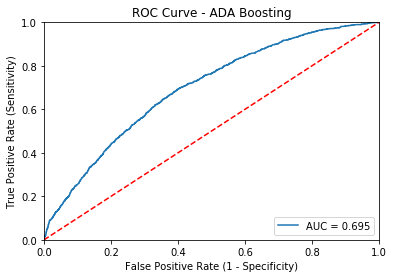

In [89]:
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
preds = clf.predict_proba(features_test)[:,1]

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), preds)
auc = metrics.auc(fpr,tpr)

plt.title("ROC Curve - ADA Boosting")
plt.plot(fpr,tpr,label='AUC = '+ str(round(auc,3)))
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.show()

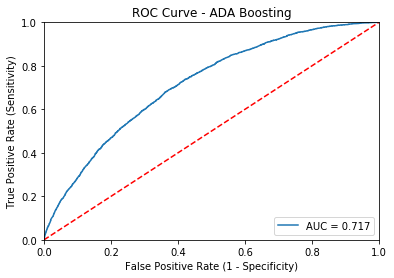

In [90]:
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
preds = clf.predict_proba(features_train)[:,1]

fpr, tpr, _ = metrics.roc_curve(np.array(label_train), preds)
auc = metrics.auc(fpr,tpr)

plt.title("ROC Curve - ADA Boosting")
plt.plot(fpr,tpr,label='AUC = '+ str(round(auc,3)))
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.show()

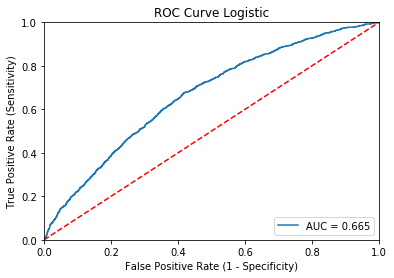

In [92]:
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
preds = clf.predict_proba(features_test)[:,1]

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), preds)
auc = metrics.auc(fpr,tpr)

plt.title("ROC Curve Logistic")
plt.plot(fpr,tpr,label='AUC = '+ str(round(auc,3)))
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.show()

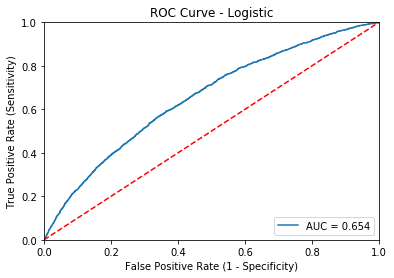

In [98]:
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
preds = clf.predict_proba(features_train)[:,1]

fpr, tpr, _ = metrics.roc_curve(np.array(label_train), preds)
auc = metrics.auc(fpr,tpr)

plt.title("ROC Curve - Logistic")
plt.plot(fpr,tpr,label='AUC = '+ str(round(auc,3)))
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.show()

# Five fold cross validation

In [94]:
from sklearn.model_selection import cross_val_score
clf = AdaBoostClassifier()
scores = cross_val_score(clf, features_train, label_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.83 (+/- 0.01)


In [95]:
clf = LogisticRegression()
scores = cross_val_score(clf, features_train, label_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.83 (+/- 0.00)
